In [1]:
import sys
sys.path.insert(0, '../')
from util import util
import numpy as np
import scipy.stats as st

import matplotlib.pyplot as plt

from scipy.optimize import minimize
import pymc3 as pm
import pandas as pd
import seaborn as sns

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import pymc3.sampling as sampling

In [3]:
x = np.arange (-1, 1, 0.01)

#Y1 = st.beta(a = 2,b=5,loc=-1,scale=2)
Y1 = st.beta(a = 2,b=2,loc=-1,scale=2)

In [5]:
samples = Y1.rvs(10)

N_SAMPLES = 1000
#sample_min = np.min(samples)
#sample_max = np.max(samples)
#scaled_samples = (samples - sample_min*1.02)/(sample_max-sample_min+0.04)

In [6]:
scaled_samples = (samples + 1)/(2)

In [ ]:
with pm.Model() as beta_model:
    alpha_dist = pm.Uniform('alpha',lower=1.0, upper=7.0)
    beta_dist = pm.Uniform('beta',lower=1.0, upper=7.0)
    observed = pm.Beta('obs',alpha=alpha_dist,beta=beta_dist,
                         observed=scaled_samples)
    map_estimate = pm.find_MAP(model=beta_model)

    # Using Metropolis Hastings Sampling
    step = pm.Metropolis()
    
    # Sample from the posterior using the sampling method
    beta_trace = pm.sample(N_SAMPLES, step=step, njobs=2)

In [ ]:
# Extract the alpha and beta samples
alpha_samples = beta_trace["alpha"][300:, None]
beta_samples = beta_trace["beta"][300:, None]

In [ ]:
plt.figure(figsize=(16, 10))

plt.subplot(211)
plt.title(r"""Distribution of $\alpha$ with %d samples""" % alpha_samples.shape[0])

plt.hist(alpha_samples, histtype='stepfilled', 
         color = 'darkred', bins=30, alpha=0.8, density=True);
plt.ylabel('Probability Density')


plt.subplot(212)
plt.title(r"""Distribution of $\beta$ with %d samples""" % beta_samples.shape[0])
plt.hist(beta_samples, histtype='stepfilled', 
         color = 'darkblue', bins=30, alpha=0.8, density=True)
plt.ylabel('Probability Density');

In [ ]:
def bayesian_beta(samples,loc=-1,scale=2,n_samples=1000):
    # known scaling
    scaled_samples = (samples - loc)/(scale)
    with pm.Model() as beta_model:
        alpha_dist = pm.Uniform('alpha',lower=1.0, upper=7.0)
        beta_dist = pm.Uniform('beta',lower=1.0, upper=7.0)
        observed = pm.Beta('obs',alpha=alpha_dist,beta=beta_dist,
                             observed=scaled_samples)
        #map_estimate = pm.find_MAP(model=beta_model)

        # Using Metropolis Hastings Sampling
        step = pm.Metropolis()

        # Sample from the posterior using the sampling method
        beta_trace = pm.sample(n_samples, step=step, njobs=4,progressbar=False,cores=4)
    return beta_model,beta_trace

In [ ]:
from collections import defaultdict

def run_ppc(trace, samples=100, model=None):
    """Generate Posterior Predictive samples from a model given a trace.
    """
    if model is None:
         model = pm.modelcontext(model)

    ppc = defaultdict(list)
    for idx in np.random.randint(0, len(trace), samples):
        param = trace[idx]
        for obs in model.observed_RVs:
            ppc[obs.name].append(obs.distribution.random(point=param))

    return ppc

In [ ]:
predictions = np.array(run_ppc(beta_trace,samples=100,model=beta_model)['obs'])
plt.hist(np.reshape(predictions,(-1,1)))

In [7]:
f1 = lambda x,y: -x*y + 5*x**2 + 2*x 
# concave function in x
f1_mean = lambda x,y: np.mean(f1(x,y),axis=0)

In [ ]:
new_res = minimize(f1_mean,res.x,args=(predictions*2-1))
new_res.x

## Compare SAA with Bayes

In [ ]:
df = pd.DataFrame(columns=['method','N','x_star'])

In [9]:
n_trials = 5
N = [10,20,50]

In [ ]:
for i in range(n_trials):
    for j in range(len(N)):
        samples = Y1.rvs(N[j])
        # compute saa
    
        res = minimize(f1_mean,0.0,args=(samples))
        results ={'method':'SAA','N':N[j],'x_star':res.x[0]}
        df = df.append(results,ignore_index=True)

        # compute bayesuian
        model,trace = bayesian_beta(samples)
        #new_samples = np.array(run_ppc(trace, samples=200, model=model)['obs'])
        obs = sampling.sample_ppc(beta_trace,samples=50,model=beta_model,size=500,progressbar=False)
        new_samples = np.reshape(obs['obs'],-1,1)
        res = minimize(f1_mean,res.x,args=(new_samples*2-1))
        
        results ={'method':'Bayes','N':N[j],'x_star':res.x[0]}
        df = df.append(results,ignore_index=True)

In [ ]:
#df.to_csv("bayes_results.csv")

In [3]:
df = pd.read_csv("bayes_results.csv")

In [8]:
samples = Y1.rvs(7000)
# compute saa
res = minimize(f1_mean,0.0,args=(samples))
true = res.x[0]

In [10]:
results =[{'method':'True','N':n,'x_star':res.x[0]} for n in N]
#df = df.append(results,ignore_index=True)

In [11]:
df = df.append(results,ignore_index=True)

/home/harrison/.virtualenvs/python3/lib/python3.5/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


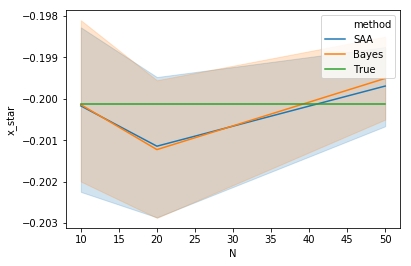

In [15]:
ax = sns.lineplot(x="N", y="x_star", hue="method",data=df)

In [16]:
samples = Y1.rvs(10000)
func = lambda x: np.mean(f1(x,samples))
df.loc[:,'expected_cost'] = df.loc[:,'x_star'].apply(func)

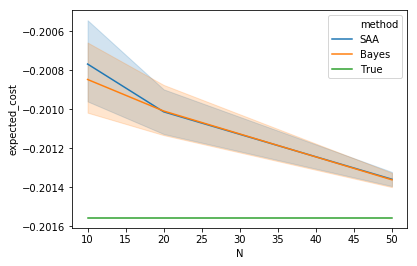

In [18]:
ax = sns.lineplot(x="N", y="expected_cost", hue="method",data=df)